# Default Loan Classification

This notebooks shows the EDA work that I have done to familarize with the dataset and create some basic visualizations on the extracted features. For the plots, the green ones (left) correspond to good loans and the red ones correspond to bad loans (default) if we define default as those loans with `status` of `B` or `D`.

## 1. Connect to MySQL Database

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MysqlIO:
    """Connect to MySQL server with python and excecute SQL commands."""
    def __init__(self, database='test'):
        try:
            # Change the host, user and password as needed
            connection = mysql.connector.connect(host='localhost',
                                                 database=database,
                                                 user='Zhou',
                                                 password='jojojo',
                                                 use_pure=True
                                                 )
            if connection.is_connected():
                db_info = connection.get_server_info()
                print("Connected to MySQL Server version", db_info)
                print("Your're connected to database:", database)
                self.connection = connection
        except Exception as e:
            print("Error while connecting to MySQL", e)
            
    def execute(self, query, header=False):
        """Execute SQL commands and return retrieved queries."""
        cursor = self.connection.cursor(buffered=True)
        cursor.execute(query)
        try:
            record = cursor.fetchall()
            if header:
                header = [i[0] for i in cursor.description]
                return {'header': header, 'record': record}
            else:    
                return record
        except:
            pass
        
    def to_df(self, query):
        """Return the retrieved SQL queries into pandas dataframe."""
        res = self.execute(query, header=True)
        df = pd.DataFrame(res['record'])
        df.columns = res['header']
        return df

In [3]:
db = MysqlIO('bank')

Connected to MySQL Server version 8.0.21
Your're connected to database: bank


## 2. Exploratory Data Analysis

### Loan and Account

- 606 good loans and 76 bad
- Features extracted:
    - loan amount
    - loan duration
    - loan payment
    - account district id
    - frequency
    - date loan issued
    - date account opened
    - days between

In [4]:
query = """
    select *
    from Loan join Account using(account_id);
    """
df = db.to_df(query)

In [5]:
df.sample(10)

account_id  loan_id        date  amount  duration payments status  \
538       10280     7100  1997-12-31  348120        60  5802.00      C   
467        9159     6857  1998-06-08   69600        48  1450.00      C   
41        10738     7192  1994-12-21  115992        36  3222.00      A   
366        4361     5868  1997-03-29   90156        12  7513.00      A   
394        7240     6486  1998-01-15  152160        60  2536.00      C   
373        5591     6142  1997-01-21  221880        60  3698.00      C   
504        6950     6415  1997-02-12  475680        48  9910.00      C   
205        1583     5282  1996-08-24  388512        48  8094.00      D   
361        2062     5366  1996-10-29   86184        12  7182.00      A   
348        4851     5988  1996-08-22  141648        24  5902.00      A   

     district_id           frequency        date  
538           69    POPLATEK MESICNE  1996-12-01  
467           64    POPLATEK MESICNE  1996-08-02  
41            45      POPLATEK TYDNE  1993-04-17  
366           69    POPLATEK MESICNE  1996-03-11  
394           17    POPLATEK MESICNE  1996-04-23  
373            9    POPLATEK MESICNE  1996-03-16  
504           36    POPLATEK MESICNE  1996-10-12  
205           69  POPLATEK PO OBRATU  1994-11-17  
361           70    POPLATEK MESICNE  1996-03-06  
348           52    POPLATEK MESICNE  1996-02-04

In [6]:
df_good = df.loc[(df['status'] == 'A') | (df['status'] == 'C')]
df_bad = df.loc[(df['status'] == 'B') | (df['status'] == 'D')]

In [7]:
# Good loans
df_good.shape[0]

606

In [8]:
# Bad loans
df_bad.shape[0]

76

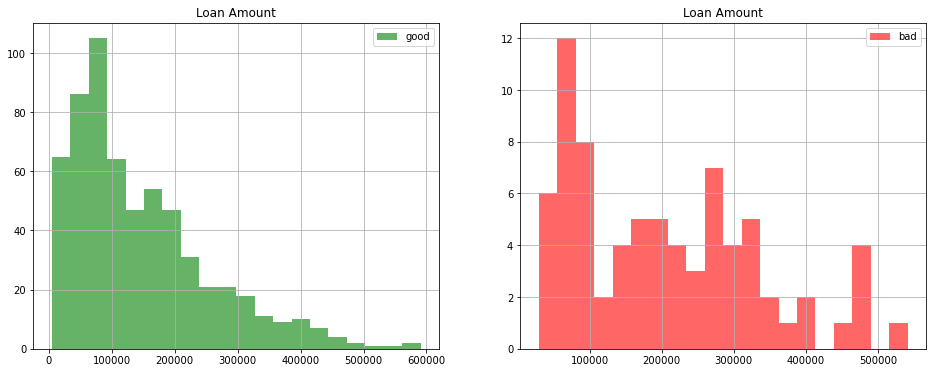

In [9]:
# Amount
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.amount.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.amount.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
ax1.set_title('Loan Amount')
ax2.set_title('Loan Amount')
ax1.legend()
ax2.legend()
plt.show()

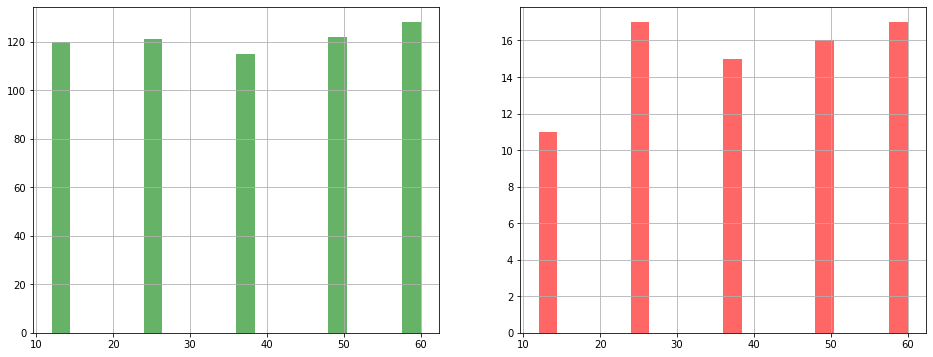

In [10]:
# duration
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.duration.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.duration.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

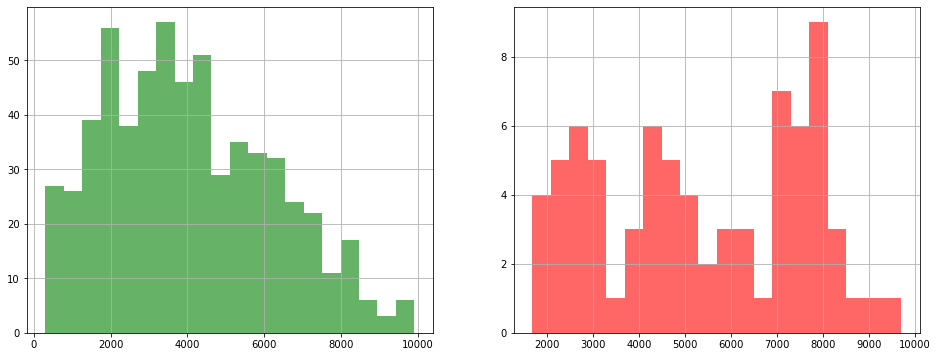

In [11]:
# payments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.payments.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.payments.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

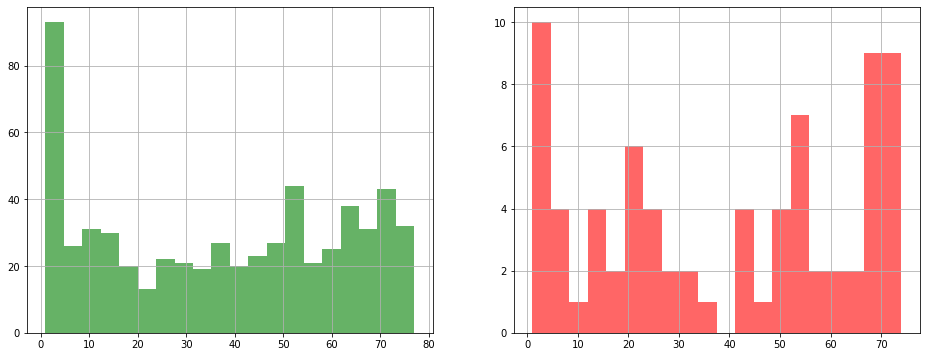

In [12]:
# district_id
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.district_id.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.district_id.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

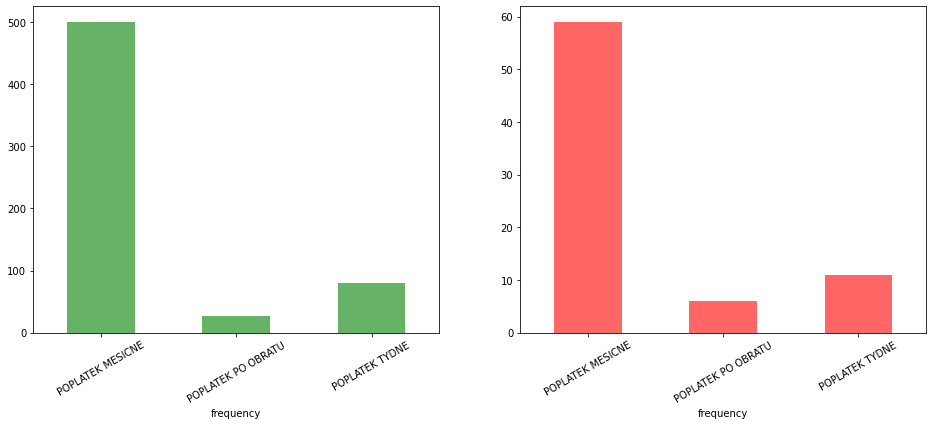

In [13]:
# frequency
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good[['account_id', 'frequency']].groupby('frequency').count().plot(
    kind='bar', color='green', rot=30, ax=ax1, alpha=0.6, legend=False)
df_bad[['account_id', 'frequency']].groupby('frequency').count().plot(
    kind='bar', color='red', rot=30, ax=ax2, alpha=0.6, legend=False)
plt.show()

In [14]:
query = """
    select Loan.date date_loan, Account.date date_acc, status
    from Loan join Account using(account_id);
    """
df = db.to_df(query)

In [15]:
df['date_loan'] = pd.to_datetime(df.date_loan, format='%Y-%m-%d')
df['date_acc'] = pd.to_datetime(df.date_acc, format='%Y-%m-%d')
df['days_between'] = df['date_loan'] - df['date_acc']
df_good = df.loc[(df['status'] == 'A') | (df['status'] == 'C')]
df_bad = df.loc[(df['status'] == 'B') | (df['status'] == 'D')]

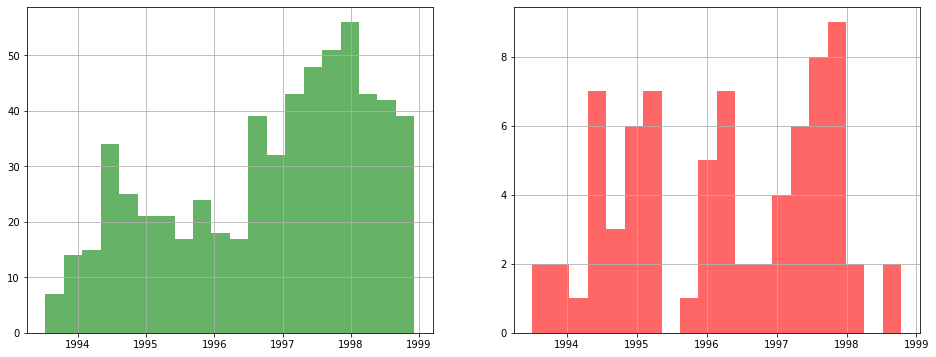

In [16]:
# date loan issued
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.date_loan.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.date_loan.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

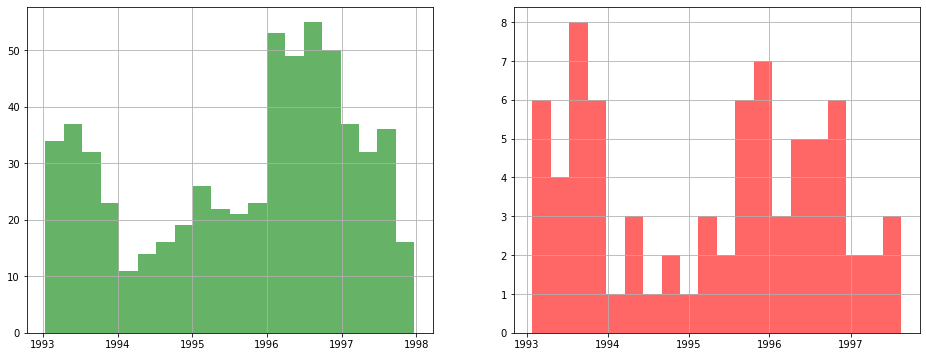

In [17]:
# date account opened
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.date_acc.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.date_acc.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

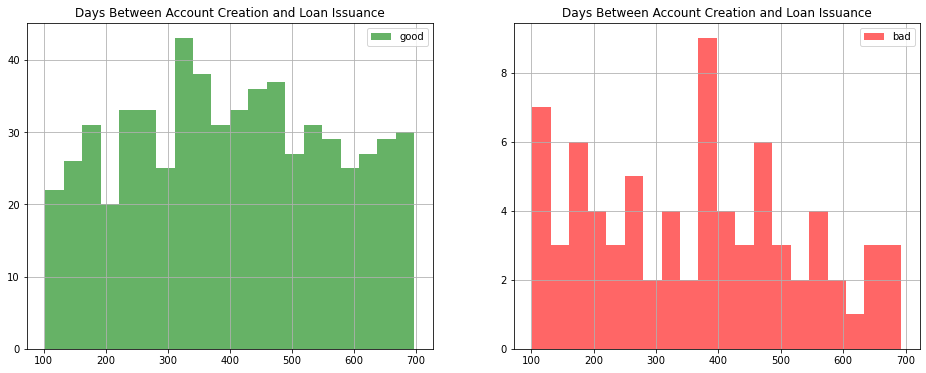

In [18]:
# days_between
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.days_between.dt.days.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.days_between.dt.days.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
ax1.set_title('Days Between Account Creation and Loan Issuance')
ax2.set_title('Days Between Account Creation and Loan Issuance')
ax1.legend()
ax2.legend()
plt.show()

### Loan and Account Districts

- Features extracted:
    - district number of inhabitants
    - district average salary
    - district average unemployment rate
    - district entrepreneur rate
    - district average crime rate

In [19]:
query = """
    select *
    from Loan join Account using(account_id)
    join district using(district_id);
    """
df = db.to_df(query)

In [20]:
df['n_inhabitants'] = df.A4
df['average_salary'] = df.A11
df['average_unemployment_rate'] = df[['A12', 'A13']].mean(axis=1)
df['entrepreneur_rate'] = df['A14']
df['average_crime_rate'] = df[['A15', 'A16']].mean(axis=1) / df['n_inhabitants']

In [21]:
df_good = df.loc[(df['status'] == 'A') | (df['status'] == 'C')]
df_bad = df.loc[(df['status'] == 'B') | (df['status'] == 'D')]

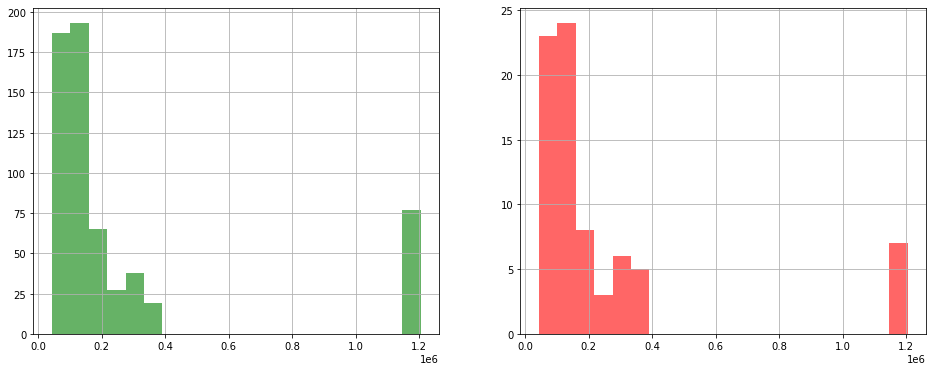

In [22]:
# n_inhabitants
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.n_inhabitants.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.n_inhabitants.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

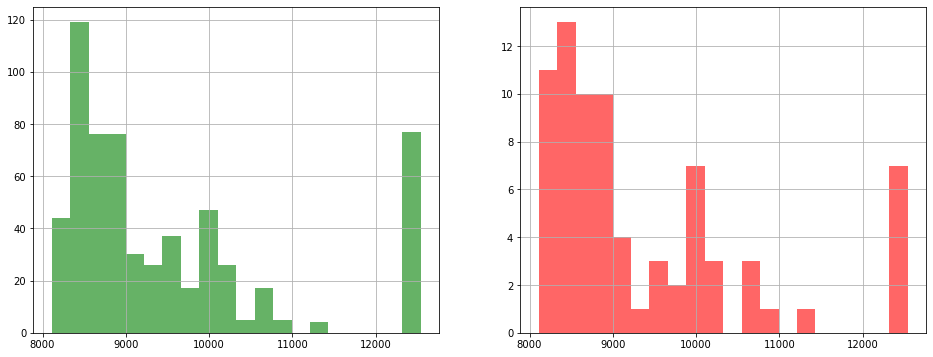

In [23]:
# average_salary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.average_salary.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.average_salary.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

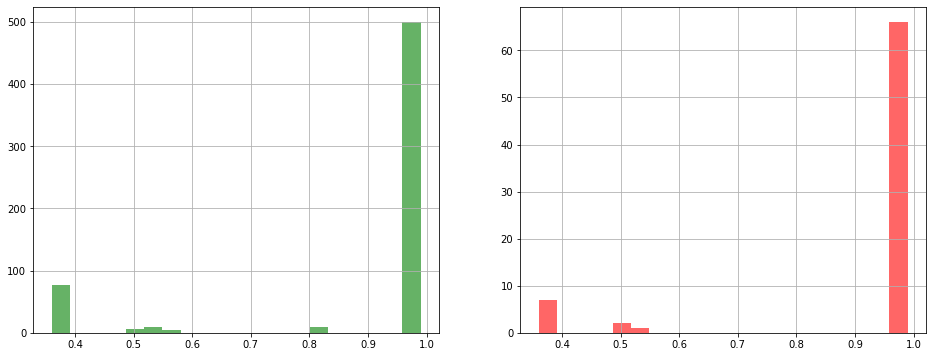

In [24]:
# average_unemployment_rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.average_unemployment_rate.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.average_unemployment_rate.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

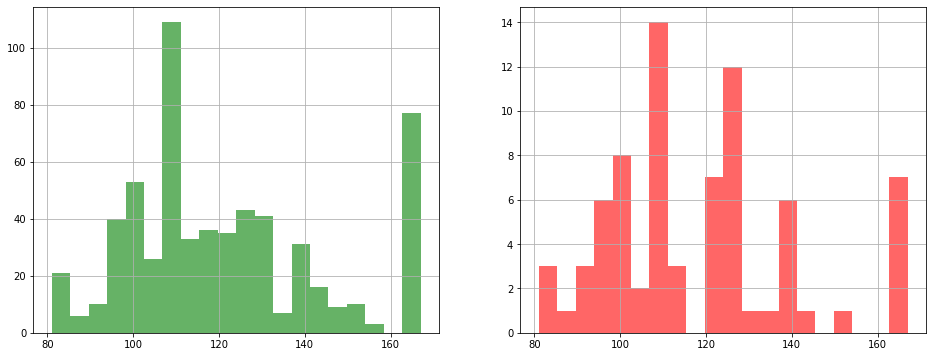

In [25]:
# entrepreneur_rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.entrepreneur_rate.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.entrepreneur_rate.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

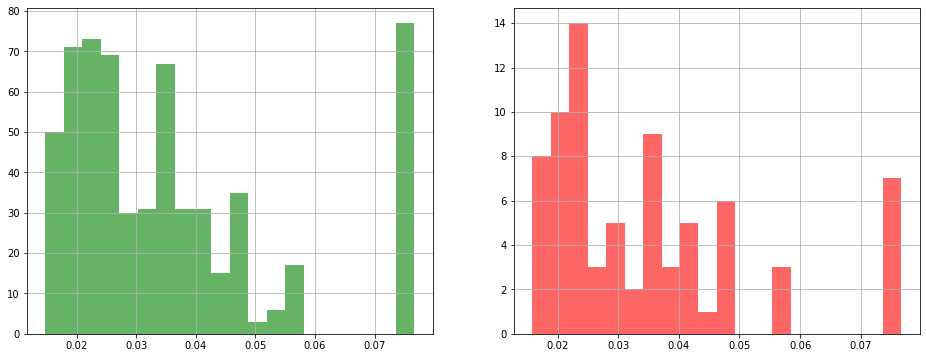

In [26]:
# average_crime_rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.average_crime_rate.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.average_crime_rate.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

### Loan and Payment Orders

- Features extracted:
    - average order amount

In [27]:
query = """
    select *
    from Loan;
    """
df = db.to_df(query)

In [28]:
query = """
    select account_id, amount order_amount
    from `Order`
    where account_id in (
        select account_id
        from Loan);
    """
df_order = db.to_df(query)

In [29]:
df_order['order_amount'] = df_order.order_amount.astype('float')

In [30]:
df = df.set_index('account_id').join(df_order.groupby('account_id').mean())
df = df.rename(columns={'order_amount': 'average_order_amount'})

In [31]:
df_good = df.loc[(df['status'] == 'A') | (df['status'] == 'C')]
df_bad = df.loc[(df['status'] == 'B') | (df['status'] == 'D')]

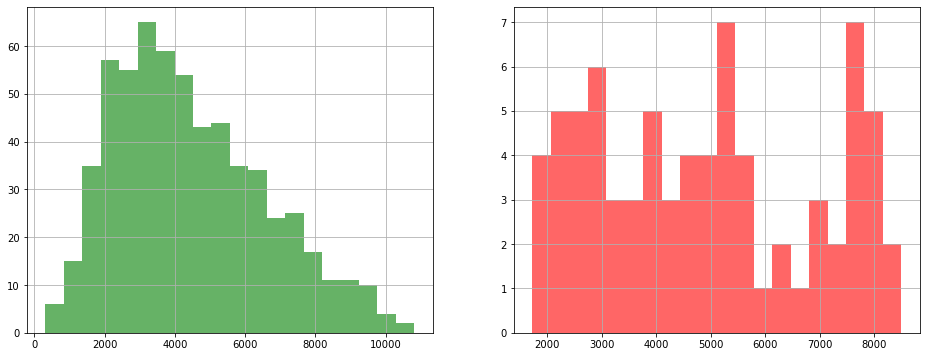

In [32]:
# average_order_amount
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.average_order_amount.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.average_order_amount.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

### Loan and Transactions

- Features extracted:
    - average transaction amount
    - average transaction balance
    - number of transactions

In [33]:
query = """
    select *
    from Loan;
    """
df = db.to_df(query)

In [34]:
query = """
    select account_id, amount trans_amount, balance trans_balance
    from Trans
    where account_id in (
        select account_id
        from Loan);
    """
df_trans = db.to_df(query)

In [35]:
n_trans = df_trans.groupby('account_id').count().iloc[:, 1]
n_trans.name = 'n_trans'

In [36]:
df_trans = df_trans.groupby('account_id').mean()
df_trans.columns = ['average_trans_amount', 'average_trans_balance']

In [37]:
df = df.set_index('account_id').join(df_trans).join(n_trans)

In [38]:
df_good = df.loc[(df['status'] == 'A') | (df['status'] == 'C')]
df_bad = df.loc[(df['status'] == 'B') | (df['status'] == 'D')]

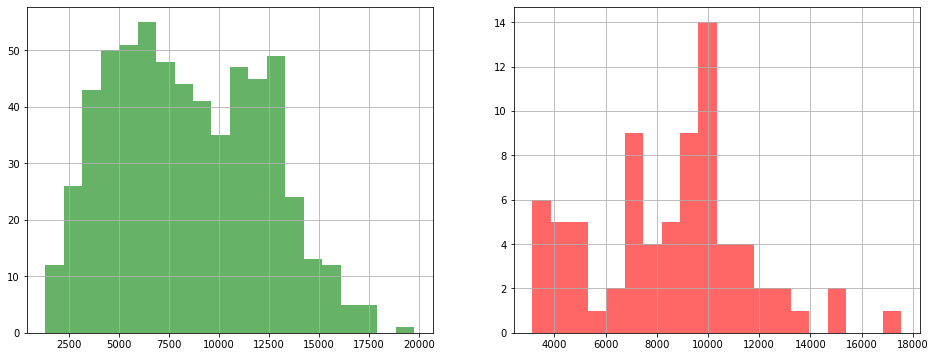

In [39]:
# average_trans_amount
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.average_trans_amount.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.average_trans_amount.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

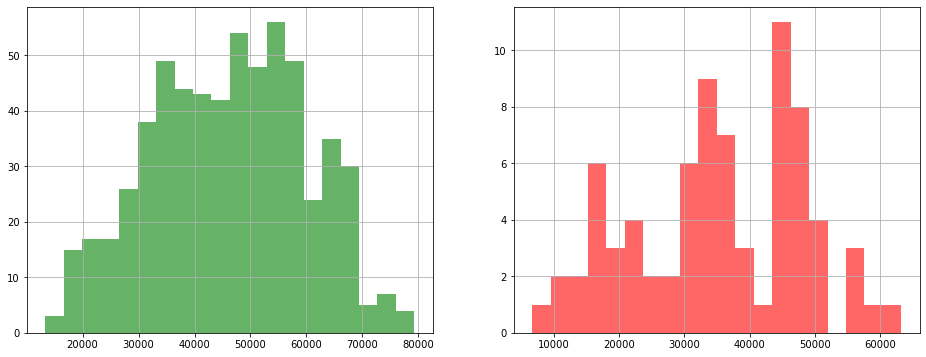

In [40]:
# average_trans_balance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.average_trans_balance.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.average_trans_balance.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

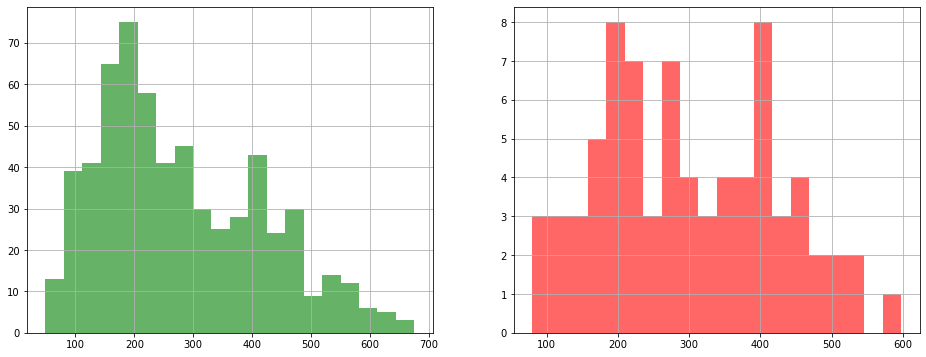

In [41]:
# n_trans
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.n_trans.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.n_trans.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

### Loan Account and Credit Card

- Features extracted:
    - Card type

In [42]:
query = """
    select account_id, card_id, Card.type card_type, status
    from Loan join Disposition using(account_id)
    left join Card using(disp_id);
    """
df = db.to_df(query)

In [43]:
# In the dataset, 1 card only corresponds to 1 account
df_with_card = df[~df['card_type'].isna()]
df_with_card.card_id.unique().shape[0] == df_with_card.shape[0]

True

In [44]:
df_good = df.loc[(df['status'] == 'A') | (df['status'] == 'C')]
df_bad = df.loc[(df['status'] == 'B') | (df['status'] == 'D')]

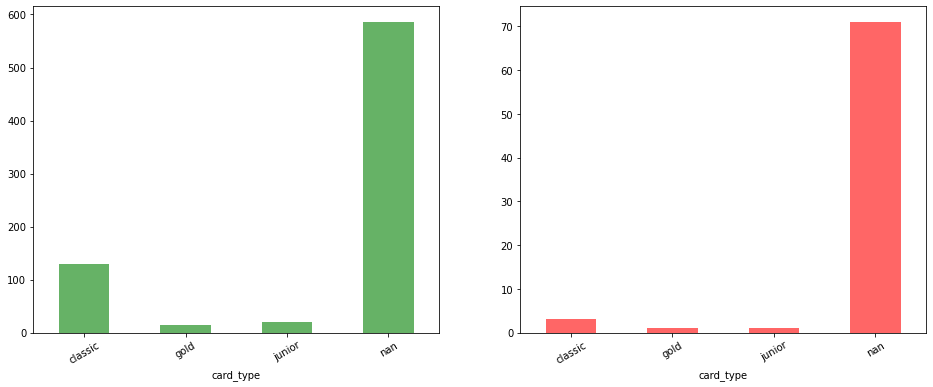

In [45]:
# card type
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good[['account_id', 'card_type']].groupby('card_type', dropna=False).count().plot(
    kind='bar', color='green', rot=30, ax=ax1, alpha=0.6, legend=False)
df_bad[['account_id', 'card_type']].groupby('card_type', dropna=False).count().plot(
    kind='bar', color='red', rot=30, ax=ax2, alpha=0.6, legend=False)
plt.show()

### Account and Client

- Features extracted:
    - Account and owner has same district
    - owner gender
    - owner age

In [46]:
query = """
    select *
    from Loan join Disposition using(account_id)
    join Client using(client_id)
    join District using(district_id);
    """

In [47]:
df = db.to_df(query)

In [48]:
query = """
    select account_id, district_id acc_dist_id
    from Loan join Account using(account_id);
    """

In [49]:
df_acc = db.to_df(query)

In [50]:
df = df.set_index('account_id').join(df_acc.set_index('account_id'))
df = df[df['type'] == 'OWNER']
df.reset_index(inplace=True)

In [51]:
# In the dataset at most 1 loan is owned by the account owner
df['account_id'].unique().shape[0]

682

In [52]:
df['same_district'] = df['district_id'] == df['acc_dist_id']

In [53]:
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
df['birth_date'] = pd.to_datetime(df.birth_date, format='%Y-%m-%d')
df['owner_age'] = (df['date'] - df['birth_date']).dt.days // 365

In [54]:
df_good = df.loc[(df['status'] == 'A') | (df['status'] == 'C')]
df_bad = df.loc[(df['status'] == 'B') | (df['status'] == 'D')]

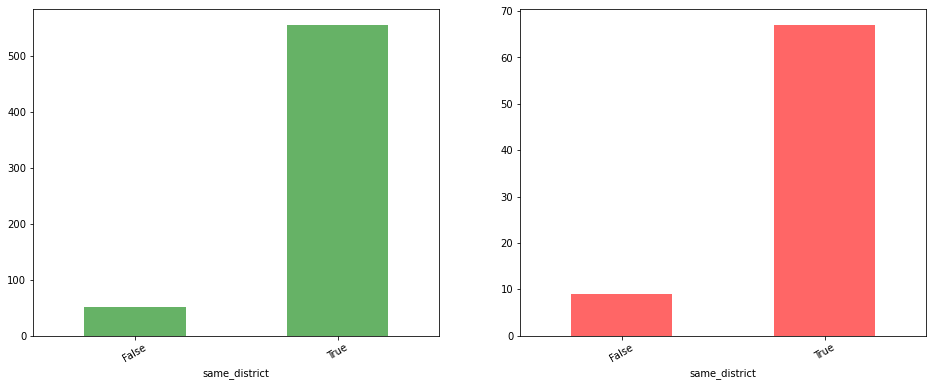

In [55]:
# Account owner and account is in the same district
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good[['account_id', 'same_district']].groupby('same_district').count().plot(
    kind='bar', color='green', rot=30, ax=ax1, alpha=0.6, legend=False)
df_bad[['account_id', 'same_district']].groupby('same_district').count().plot(
    kind='bar', color='red', rot=30, ax=ax2, alpha=0.6, legend=False)
plt.show()

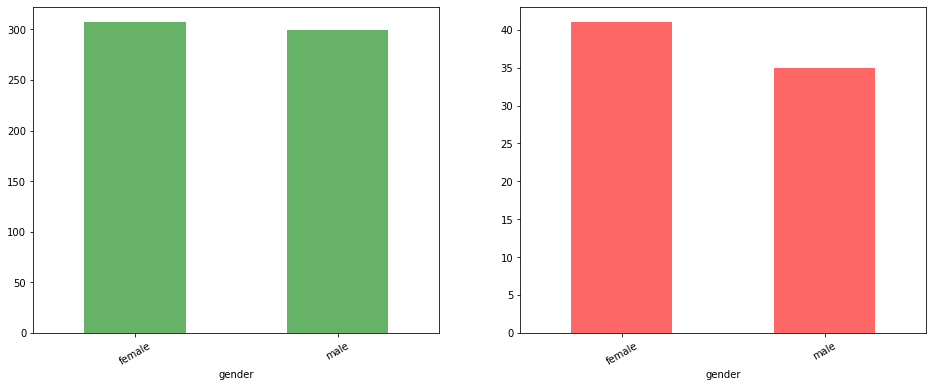

In [56]:
# Gender
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good[['account_id', 'gender']].groupby('gender').count().plot(
    kind='bar', color='green', rot=30, ax=ax1, alpha=0.6, legend=False)
df_bad[['account_id', 'gender']].groupby('gender').count().plot(
    kind='bar', color='red', rot=30, ax=ax2, alpha=0.6, legend=False)
plt.show()

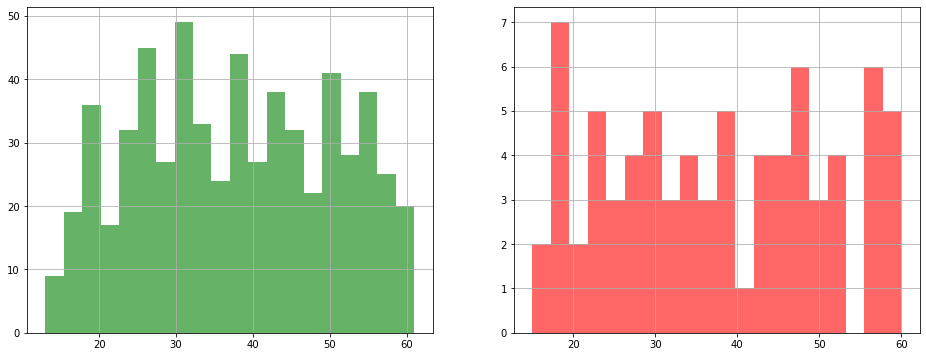

In [57]:
# owner age
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good.owner_age.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad.owner_age.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()